In [59]:
import time
import pickle
import logging
import collections

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise

from gensim.models import doc2vec

import crashsimilarity.tmp as tmp
import crashsimilarity.other_distances as od
import crashsimilarity.metrics as metrics
from crashsimilarity.distance import DistanceCalculator

In [2]:
vocab = pickle.load(open('data/compressed_vocab.pickle', 'rb'))
pos2vocab = dict([(i[1], i[0]) for i in vocab.items()])
len(vocab)

222895

In [3]:
model = doc2vec.Doc2Vec.load('data/new-model/model_dm_200_30_days.model')
model

INFO:gensim.utils:loading Doc2Vec object from data/new-model/model_dm_200_30_days.model
INFO:gensim.utils:loading wv recursively from data/new-model/model_dm_200_30_days.model.wv.* with mmap=None
INFO:gensim.utils:loading syn0 from data/new-model/model_dm_200_30_days.model.wv.syn0.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:loading docvecs recursively from data/new-model/model_dm_200_30_days.model.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from data/new-model/model_dm_200_30_days.model.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn1neg from data/new-model/model_dm_200_30_days.model.syn1neg.npy with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded data/new-model/model_dm_200_30_days.model


In [48]:
corpus1 = pickle.load(open('data/model-size/multiple_sig_last_year.pickle', 'rb'))
corpus1 = [i['prepared'] for i in corpus1]
len(corpus1)

261

In [47]:
def compress_and_group(prepared):
    groups = []
    corpus = []
    true_labels = []
    for p in prepared:
        group = []
        for t in p:
            corpus.append(t)
            group.append(len(corpus)-1)
            true_labels.append(len(groups))
        groups.append(group)
    compressed_corpus = [[str(vocab.get(i, i)) for i in c] for c in corpus]
    compressed_corpus = [doc2vec.TaggedDocument(trace, [i]) for i, trace in enumerate(compressed_corpus)]
    groups = [g for g in groups if len(g) > 1]
    return compressed_corpus, corpus, groups, true_labels

In [49]:
compressed_corpus1, corpus1, groups1, true_labels1 = compress_and_group(corpus1)
len(corpus1), len(groups1), len(true_labels1)

(755, 223, 755)

In [24]:
len(corpus1[0]), len(compressed_corpus1[0].words)

(38, 38)

In [7]:
corpus2 = pickle.load(open('data/model-size/multiple_sig_year_before.pickle', 'rb'))
corpus2 = [i['prepared'] for i in corpus2]
len(corpus2)

312

In [28]:
def report(labels_true, labels_pred):
    return {'precision': metrics.my_precision(labels_true, labels_pred), 
            'recall': metrics.my_recall(labels_true, labels_pred),
            'FMI': metrics.my_FMI(labels_true, labels_pred),
            'n_clusters': len(set(labels_pred)) - (1 if -1 in labels_pred else 0),
            'noise': float(len([i for i in labels_pred if i == -1])) / len(labels_true)
           }

In [91]:
GLOBAL_CACHE = dict()
GLOBAL_CACHE['wmd'] = dict()
GLOBAL_CACHE['ed'] = dict()
GLOBAL_CACHE['ed_struct'] = dict()
GLOBAL_CACHE['ed_embedding'] = dict()
def cacheable(fun, cache):
    def ret(arg1, arg2):
        ka1 = arg1 if isinstance(arg1, collections.Hashable) else tuple(arg1)
        ka2 = arg2 if isinstance(arg2, collections.Hashable) else tuple(arg2)
        key = (ka1, ka2)
        if key not in cache:
            cache[key] = fun(arg1, arg2)
        return cache[key]
    return ret

In [217]:
def iterate_eps(dist, labels_true, min_samples=2, eps=None, steps=None):
    if eps:
        if not isinstance(eps, list):
            eps = [eps]
    else:
        max_dist = np.max(dist)
        min_dist = np.min(dist)
        steps = steps or 100
        eps = np.linspace(min_dist, max_dist, steps)
    results = []
    for e in eps:
        try:
            labels_pred, *_ = od.dbscan(dist, e, min_samples)
            results.append((e, report(labels_true, labels_pred)))
        except ValueError:
            pass
    return results

In [232]:
def build_distance_calculator(compressed_corpus, model):
    dist, w2pos =  DistanceCalculator.words_distance(compressed_corpus, model)
    return DistanceCalculator(model, w2pos, dist)

In [234]:
distance_calculator = build_distance_calculator(compressed_corpus1, model)

len(words) = 2808


In [231]:
def cluster_wmd(compressed_corpus, distance_calculator, labels_true, min_samples=2, eps=None, steps=None):
    cacheable_fast_wmd = cacheable(distance_calculator.fast_wmd, GLOBAL_CACHE['wmd'])
    
    wmd = od.distance_matrix(compressed_corpus, cacheable_fast_wmd)
    wmd[wmd == np.inf] = -1
    m = np.max(wmd)
    wmd[wmd == -1] = m
    
    return iterate_eps(wmd, labels_true, min_samples, eps, steps)

In [219]:
def cluster_ed(compressed_corpus, labels_true, min_samples=2, eps=None, steps=None):
    cacheable_edit_distance2 = cacheable(od.edit_distance2, GLOBAL_CACHE['ed'])
    dist = od.distance_matrix(compressed_corpus, cacheable_edit_distance2)
    return iterate_eps(dist, labels_true, min_samples, eps, steps)

In [229]:
def cluster_ed_struct(corpus, labels_true, min_samples=2, eps=None, steps=None):
    class Tmp(object):
        def __init__(self, words):
            self.words = words
    def struct_dist_calc(s1, s2):
        return od.edit_distance2(s1, s2, subst_cost=od.struct_word_dist)
    cacheable_struct_dist_calc = cacheable(struct_dist_calc, GLOBAL_CACHE['ed_struct'])
    dist = od.distance_matrix([Tmp(i) for i in corpus], cacheable_struct_dist_calc)
    return iterate_eps(dist, labels_true, min_samples, eps, steps)

In [246]:
def cluster_ed_embedding(compressed_corpus, distance_calculator, labels_true, min_samples=2, eps=None, steps=None):
    def words_dist(s1, s2):
        res = distance_calculator.compressed_words_dist(s1, s2)
        return res if res >= 0 else 2
    def semantic_dist(s1, s2):
        return od.edit_distance2(s1, s2,
                                 ins_cost=words_dist,
                                 del_cost=words_dist,
                                 subst_cost=words_dist)
    cacheable_semantic_dist = cacheable(semantic_dist, GLOBAL_CACHE['ed_embedding'])
    dist = od.distance_matrix(compressed_corpus, cacheable_semantic_dist)
    return iterate_eps(dist, labels_true, min_samples, eps, steps)

In [251]:
def cluster_ed_embedding_only_subst(compressed_corpus, distance_calculator, labels_true, min_samples=2, eps=None, steps=None):
    def words_dist(s1, s2):
        res = distance_calculator.compressed_words_dist(s1, s2)
        return res if res >= 0 else 2
    semantic_dist = lambda s1, s2: od.edit_distance2(s1, s2,
                                                     ins_cost=lambda a,b: 2,
                                                     del_cost=lambda a,b: 2,
                                                     subst_cost=words_dist)
    cacheable_semantic_dist = cacheable(semantic_dist, GLOBAL_CACHE['ed_embedding_only_subst'])
    dist = od.distance_matrix(compressed_corpus, cacheable_semantic_dist)
    return iterate_eps(dist, labels_true, min_samples, eps, steps)

In [182]:
def cluster_paragraph_vec(compressed_corpus, model, labels_true, min_samples=2, eps=None, steps=None):
    vectors = [model.infer_vector(i.words) for i in compressed_corpus]
    dist_euc = pairwise.euclidean_distances(vectors)
    return iterate_eps(dist_euc, labels_true, min_samples, eps, steps)    

In [187]:
res_pv = cluster_paragraph_vec(compressed_corpus1, model, true_labels1, steps=20)

In [221]:
res_ed = cluster_ed(compressed_corpus1, true_labels1, steps=20)

9.999824336430867%, 0.2523798942565918 s.
19.999648672861735%, 0.48029184341430664 s.
29.999473009292604%, 0.7380695343017578 s.
39.99929734572347%, 0.9714715480804443 s.
49.99912168215434%, 1.1903350353240967 s.
59.99894601858521%, 1.406470537185669 s.
69.99877035501608%, 1.6244194507598877 s.
79.99859469144694%, 1.84901762008667 s.
89.99841902787782%, 2.0795845985412598 s.
99.99824336430868%, 2.3060975074768066 s.


In [254]:
fff = sorted([i for i in res_ed if True], key=lambda x: x[1]['FMI'], reverse=True)
fff[0]

(2.1052631578947367,
 {'FMI': 0.40614552623619454,
  'n_clusters': 100,
  'noise': 0.5880794701986755,
  'precision': 0.3717277486910995,
  'recall': 0.44375})

In [235]:
res_ed_struct = cluster_ed_struct(corpus1, true_labels1, steps=20)

9.999824336430867%, 0.27698493003845215 s.
19.999648672861735%, 0.5093905925750732 s.
29.999473009292604%, 0.7694272994995117 s.
39.99929734572347%, 1.010430097579956 s.
49.99912168215434%, 21.314476013183594 s.
59.99894601858521%, 65.26431226730347 s.
69.99877035501608%, 107.89246392250061 s.
79.99859469144694%, 153.3189868927002 s.
89.99841902787782%, 197.6563262939453 s.
99.99824336430868%, 240.40479803085327 s.


In [244]:
www = sorted([i for i in res_ed_struct if True], key=lambda x: x[1]['FMI'], reverse=True)
www[0]

(2.1052631578947367,
 {'FMI': 0.42958004377146597,
  'n_clusters': 97,
  'noise': 0.5814569536423841,
  'precision': 0.43205128205128207,
  'recall': 0.42712294043092525})

In [248]:
res_ed_embedding = cluster_ed_embedding(compressed_corpus1, distance_calculator, true_labels1, steps=20)

9.999824336430867%, 186.9552938938141 s.
19.999648672861735%, 371.9465489387512 s.
29.999473009292604%, 533.4724044799805 s.
39.99929734572347%, 743.080971956253 s.
49.99912168215434%, 1002.923290014267 s.
59.99894601858521%, 1219.9143681526184 s.
69.99877035501608%, 1437.819355726242 s.
79.99859469144694%, 1664.4323379993439 s.
89.99841902787782%, 1878.611498117447 s.
99.99824336430868%, 2094.5802342891693 s.


In [252]:
res_ed_embedding_only_subst =  cluster_ed_embedding_only_subst(compressed_corpus1, distance_calculator, true_labels1, steps=20)

9.999824336430867%, 101.41087603569031 s.
19.999648672861735%, 196.45075488090515 s.
29.999473009292604%, 281.76887249946594 s.
39.99929734572347%, 391.5591015815735 s.
49.99912168215434%, 530.4024062156677 s.
59.99894601858521%, 645.6743233203888 s.
69.99877035501608%, 761.5606989860535 s.
79.99859469144694%, 881.671257019043 s.
89.99841902787782%, 993.9774885177612 s.
99.99824336430868%, 1109.11283993721 s.


In [253]:
vvv = sorted([i for i in res_ed_embedding_only_subst if True], key=lambda x: x[1]['FMI'], reverse=True)
vvv[0]

(4.2105263157894735,
 {'FMI': 0.2588954792167652,
  'n_clusters': 98,
  'noise': 0.552317880794702,
  'precision': 0.375,
  'recall': 0.17873831775700935})

In [249]:
qqq = sorted([i for i in res_ed_embedding if True], key=lambda x: x[1]['FMI'], reverse=True)
qqq[0]

(4.2105263157894735,
 {'FMI': 0.21964251474816823,
  'n_clusters': 97,
  'noise': 0.5205298013245033,
  'precision': 0.38344988344988346,
  'recall': 0.12581261950286807})

In [245]:
qqq

[(0.49824647526992294,
  {'FMI': 0.07144776636807812,
   'n_clusters': 1,
   'noise': 0.0,
   'precision': 1.0,
   'recall': 0.005104783318987475}),
 (7.7253597912035445,
  {'FMI': 0.07144776636807812,
   'n_clusters': 1,
   'noise': 0.0,
   'precision': 1.0,
   'recall': 0.005104783318987475}),
 (14.952473107137166,
  {'FMI': 0.07144776636807812,
   'n_clusters': 1,
   'noise': 0.0,
   'precision': 1.0,
   'recall': 0.005104783318987475}),
 (22.179586423070802,
  {'FMI': 0.07144776636807812,
   'n_clusters': 1,
   'noise': 0.0,
   'precision': 1.0,
   'recall': 0.005104783318987475}),
 (29.406699739004438,
  {'FMI': 0.07144776636807812,
   'n_clusters': 1,
   'noise': 0.0,
   'precision': 1.0,
   'recall': 0.005104783318987475}),
 (36.633813054938059,
  {'FMI': 0.07144776636807812,
   'n_clusters': 1,
   'noise': 0.0,
   'precision': 1.0,
   'recall': 0.005104783318987475}),
 (43.860926370871681,
  {'FMI': 0.07144776636807812,
   'n_clusters': 1,
   'noise': 0.0,
   'precision': 1.0,


In [240]:
xxx = sorted([i for i in res_pv if i[1]['noise'] < 0.8], key=lambda x: x[1]['FMI'], reverse=True)
xxx[0]

(0.64618380446183055,
 {'FMI': 0.13671823284065848,
  'n_clusters': 26,
  'noise': 0.7615894039735099,
  'precision': 0.533175355450237,
  'recall': 0.035057650358367096})

In [157]:
res = cluster_wmd(compressed_corpus1, model, true_labels1)

len(words) = 2808
9.999824336430867%, 0.2626988887786865 s.
19.999648672861735%, 0.4864795207977295 s.
29.999473009292604%, 0.7420785427093506 s.
39.99929734572347%, 0.9653105735778809 s.
49.99912168215434%, 1.1895720958709717 s.
59.99894601858521%, 1.4084179401397705 s.
69.99877035501608%, 1.6325106620788574 s.
79.99859469144694%, 1.8525664806365967 s.
89.99841902787782%, 2.0749032497406006 s.
99.99824336430868%, 2.294243812561035 s.


In [284]:
corpus1[0]

['nvd3dumx.dll@0x',
 'werpvalidatepebheader',
 '@0x',
 'heapfree',
 'nvd3dumx.dll@0x',
 'nvd3dumx.dll@0x',
 'nvd3dumx.dll@0x',
 'icmselectcolortransform',
 '@0x',
 'destroycontextcb',
 'd3d8deletedirectdrawobject',
 "`eh vector destructor iterator'",
 'cbasedevice::~cbasedevice',
 "cd3dhal::`scalar deleting destructor'",
 'cbaseobject::freeprivatedataimpl',
 '_gshandlercheck_seh',
 'idmap<t>::lookup',
 '@0x',
 "mozilla::layers::dxgid3d9texturedata::`scalar deleting destructor'",
 'mozilla::layers::destroytexturedata',
 'mozilla::layers::texturechild::actordestroy',
 'mozilla::layers::ptexturechild::onmessagereceived',
 'mozilla::layers::pimagebridgechild::onmessagereceived',
 'mozilla::ipc::messagechannel::dispatchasyncmessage',
 'mozilla::ipc::messagechannel::dispatchmessagew',
 'mozilla::ipc::messagechannel::onmaybedequeueone',
 'mozilla::detail::runnablemethodimpl<t>::run',
 'mozilla::ipc::messagechannel::dequeuetask::run',
 'messageloop::runtask',
 'messageloop::deferorrunpendingta

In [168]:
top_pre = sorted([i for i in res if i[1]['FMI'] > 0.1 and i[1]['recall'] > 0.2], key=lambda x: x[1]['noise'])
top_pre[:10]

[(0.4074780989174891,
  {'FMI': 0.35774254147920753,
   'n_clusters': 122,
   'noise': 0.43178807947019865,
   'precision': 0.4444444444444444,
   'recall': 0.2879543834640057}),
 (0.38976165983411998,
  {'FMI': 0.37463399887534193,
   'n_clusters': 120,
   'noise': 0.4463576158940397,
   'precision': 0.43512304250559286,
   'recall': 0.3225538971807628}),
 (0.37204522075075086,
  {'FMI': 0.39073469479710615,
   'n_clusters': 121,
   'noise': 0.4543046357615894,
   'precision': 0.4346846846846847,
   'recall': 0.35122838944494994}),
 (0.3543287816673818,
  {'FMI': 0.43891206928945264,
   'n_clusters': 123,
   'noise': 0.46357615894039733,
   'precision': 0.43815028901734104,
   'recall': 0.4396751740139211}),
 (0.33661234258401274,
  {'FMI': 0.46947965343972026,
   'n_clusters': 128,
   'noise': 0.4728476821192053,
   'precision': 0.4133489461358314,
   'recall': 0.5332326283987915}),
 (0.31889590350064362,
  {'FMI': 0.473825854690402,
   'n_clusters': 129,
   'noise': 0.48344370860927

In [ ]:
ALL_ALGOS = ['edit-distance', 'paragraph-vectors', 'wmd', 'edit-distance-struct', 'edit-distance-embedding']
def cluster_report(compressed_corpus, corpus, labels_true, algos):
    result = dict()
    paragraph_vectors = [model.infer_vector(i.words) for i in compressed_corpus]
    

In [23]:
vectors = [model.infer_vector(i.words) for i in corpus1]
len(vectors)

755

In [29]:
dist_cos = pairwise.cosine_distances(vectors)
dist_euc = pairwise.euclidean_distances(vectors)

In [30]:
dist_cos.shape

(755, 755)

In [32]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [46]:
labels, n_cl, mask = dbscan(dist_cos, eps=0.1, min_samples=2)

In [75]:
labels_e, n_cle, core = dbscan(dist_euc, eps=0.72, min_samples=2)

In [74]:
def plot_clusters(labels, n_clusters, core_samples_mask, dist, remove_outliers=True):
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            if remove_outliers:
                continue
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = dist[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=8)

        xy = dist[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=4)

    plt.title('Estimated number of clusters: %d' % n_clusters)
    plt.show()

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


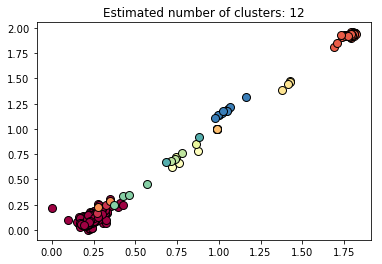

In [89]:
plot_clusters(labels, n_cl, mask, dist_cos)

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


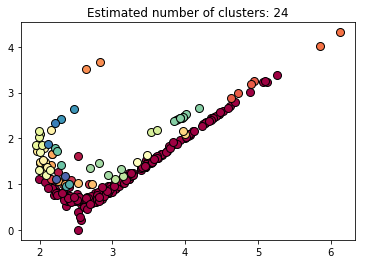

In [88]:
plot_clusters(labels_e, n_cle, core, dist_euc)

In [80]:
true_labels = [-1] * len(corpus1)
for i, g in enumerate(groups1):
    for x in g:
        true_labels[x] = i

In [84]:
fowlkes_mallows_score(true_labels, labels_e)

0.073797044337169118

In [267]:
sa = [i for i in list(vocab.keys()) if i.startswith('') and 'halt' in i]
len(sa)

14

In [268]:
sa

['sqlite3vdbehalt',
 'js::jit::x86encoding::baseassembler::haltingalign',
 'chaltable::resume',
 'createtagstringwithalternates',
 'js::jit::assemblerx86shared::haltingalign',
 'marshaltogit',
 'cobjectingit<t>::createinstanceandmarshaltogit',
 'sqlite3haltconstraint',
 'chaltable::resumeall',
 'cthreadmarshalwnd::postmarshalthreadmessage',
 'osf_cconnection::dealwithaltercontextresp',
 '__halt',
 'csession::pollhalt',
 'attachalternatestoinkobject']

In [294]:
pos2vocab[158445]

'psetupcreatetextlogsectiona'

In [289]:
model.most_similar(str(vocab['sqlite3haltconstraint']), topn=20)

[('167909', 0.9735447764396667),
 ('159682', 0.8685736060142517),
 ('159684', 0.8641253113746643),
 ('166233', 0.860828697681427),
 ('166235', 0.8605992794036865),
 ('166234', 0.859000027179718),
 ('32452', 0.8575301766395569),
 ('173283', 0.8550620675086975),
 ('145535', 0.8544099926948547),
 ('110813', 0.8528043031692505),
 ('159683', 0.852405309677124),
 ('166232', 0.8515244722366333),
 ('145536', 0.8492173552513123),
 ('158445', 0.8489628434181213),
 ('132249', 0.8485404849052429),
 ('159681', 0.8444951772689819),
 ('170864', 0.8438122868537903),
 ('139930', 0.8421785235404968),
 ('135060', 0.8416270017623901),
 ('156227', 0.841200590133667)]

In [71]:
n_cl, n_cle

(12, 24)

In [72]:
from sklearn.metrics import fowlkes_mallows_score